## Setup

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations --user

In [1]:
from torchvision.datasets import VOCSegmentation

train_data = VOCSegmentation(root='./', year='2012', image_set='train', download=True)
valid_data = VOCSegmentation(root='./', year='2012', image_set='val', download=True)


## Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim

# segmentation_models_pytorch 가 import 안되면 install 후, 세션 다시 시작하면 됨
import scipy.ndimage.morphology as morph
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import datetime
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from BEIT import BEiT3
import time

/home/yumin/miniconda3/envs/ccp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 42

def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    np.random.seed(RANDOM_SEED)
    torch.backends.cudnn.benchmark = False

set_seed()

## Visualization

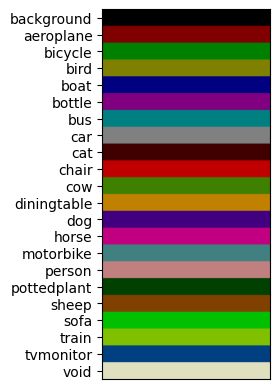

In [3]:
labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
              'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant',
              'sheep', 'sofa', 'train', 'tvmonitor', 'void']

val_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
          'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant',
          'sheep', 'sofa', 'train', 'tvmonitor', 'void']

def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

def color_map_viz():
    nclasses = len(labels) - 1
    row_size = 50
    col_size = 500
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

    plt.imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()

color_map_viz()

In [4]:
root = './VOCdevkit/'

train_path = root + 'VOC2012/ImageSets/Segmentation/train.txt'
valid_path = root + 'VOC2012/ImageSets/Segmentation/val.txt'

lines = open(train_path, "r").read().split('\n')
train_set = [line for line in lines if line.strip()]
# train_set = train_set[-50:]

lines = open(train_path, "r").read().split('\n')
valid_set = [line for line in lines if line.strip()]
# valid_set = valid_set[-50:]

img_path = root + "VOC2012/JPEGImages/"
mask_path = root + "VOC2012/SegmentationClass/"

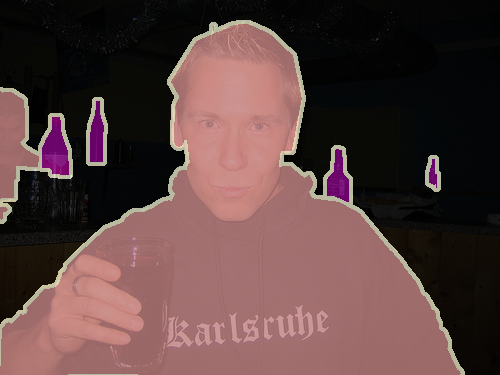

In [5]:
img_idx = 5

img = Image.open(img_path + train_set[img_idx] + '.jpg')
mask = np.array(Image.open(mask_path + train_set[img_idx] + '.png'))[:, :, np.newaxis]
cmap = color_map()[:, np.newaxis, :]

new_im = np.dot(mask == 0, cmap[0])
for i in range(1, cmap.shape[0]):
    new_im += np.dot(mask == i, cmap[i])
new_im = Image.fromarray(new_im.astype(np.uint8))
blend_image = Image.blend(img, new_im, alpha=0.8)
blend_image

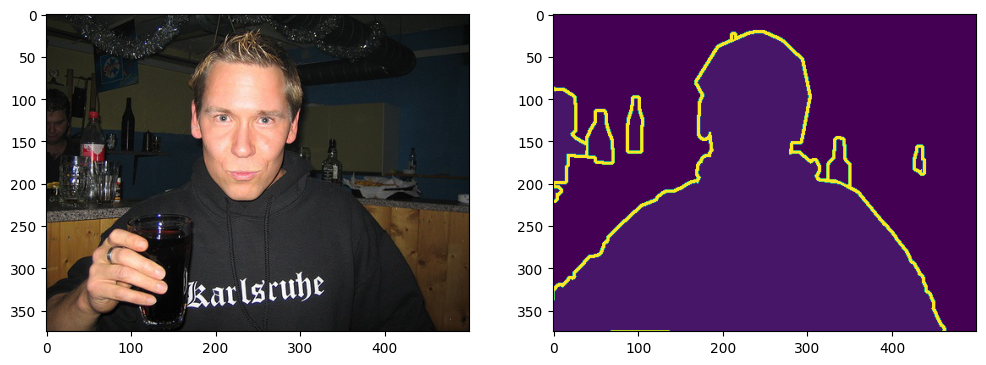

In [6]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

## Dataset

In [7]:
img_transforms = A.Compose([
    A.Resize(height=224, width=224, interpolation=1, always_apply=True),
    ToTensorV2()
])

mask_transforms = A.Compose([
    A.Resize(height=224, width=224, interpolation=0, always_apply=True),
    ToTensorV2()
])

In [8]:
class Segdata(Dataset):
    def __init__(self,files, img_path ,mask_path,labels, img_transforms=img_transforms, mask_transforms=mask_transforms):
        # self.img_path = os.listdir(img_path )
        # self.mask_path = os.listdir(mask_path)
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_transforms = img_transforms
        self.mask_transforms=mask_transforms
        self.files = files
        self.labels = len(labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        img = Image.open(self.img_path  + self.files[idx] + ".jpg")#.convert('RGB')
        mask = Image.open(self.mask_path  + self.files[idx] + ".png")

        img = np.array(img).astype(np.float32)
        mask = np.array(mask)
        mask_ = mask

        # mask(1,h,w) -> (21,h,w)
        multi_mask = np.ones((mask.shape[0], mask.shape[1], self.labels), dtype=np.float32)
        for c in range(1,self.labels+1):
            multi_mask[ :, :,c-1] = (mask == c)
        multi_mask[:,:,21] = (mask == 255)

        if self.img_transforms:
            img = img_transforms(image=img)['image']
            mask= mask_transforms(image=multi_mask)['image']

        return img, mask

In [9]:
train_dataset = Segdata(train_set, img_path, mask_path,labels, img_transforms, mask_transforms)
valid_dataset = Segdata(valid_set, img_path, mask_path,labels, img_transforms, mask_transforms)

## Dataloader

In [10]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    drop_last=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

## Train

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)

    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [12]:
SAVED_DIR = './'

def save_model(model, file_name='best_model.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [13]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.cuda()
    model.eval()

    dices = []
    with torch.no_grad():
        n_class = len(labels)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()

            outputs = model(images)

            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)

            # restore original size
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")

            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1

            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()

            dice = dice_coef(outputs, masks)
            dices.append(dice)

    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(val_labels, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)

    avg_dice = torch.mean(dices_per_class).item()

    return avg_dice

In [14]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    model.cuda()

    n_class = len(val_labels)
    best_dice = 0.

    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):
            # gpu 연산을 위해 device 할당
            images, masks = images.cuda(), masks.cuda()

            # inference
            outputs = model(images)

            # loss 계산
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )

        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)

            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)

In [15]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=1024, num_classes=len(labels)-1 ):
        super(ASPP, self).__init__()
        # atrous 3x3, rate=6
        self.conv_3x3_r6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        # atrous 3x3, rate=12
        self.conv_3x3_r12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        # atrous 3x3, rate=18
        self.conv_3x3_r18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        # atrous 3x3, rate=24
        self.conv_3x3_r24 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=24, dilation=24)
        self.drop_conv_3x3 = nn.Dropout2d(0.5)

        self.conv_1x1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.drop_conv_1x1 = nn.Dropout2d(0.5)

        self.conv_1x1_out = nn.Conv2d(out_channels, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # 1번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        # print("feature_map = ",feature_map.shape)
        out_3x3_r6 = self.drop_conv_3x3(F.relu(self.conv_3x3_r6(feature_map)))
        out_img_r6 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r6)))
        out_img_r6 = self.conv_1x1_out(out_img_r6)
        # 2번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r12 = self.drop_conv_3x3(F.relu(self.conv_3x3_r12(feature_map)))
        out_img_r12 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r12)))
        out_img_r12 = self.conv_1x1_out(out_img_r12)
        # 3번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r18 = self.drop_conv_3x3(F.relu(self.conv_3x3_r18(feature_map)))
        out_img_r18 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r18)))
        out_img_r18 = self.conv_1x1_out(out_img_r18)
        # 4번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r24 = self.drop_conv_3x3(F.relu(self.conv_3x3_r24(feature_map)))
        out_img_r24 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r24)))
        out_img_r24 = self.conv_1x1_out(out_img_r24)

        out = sum([out_img_r6, out_img_r12, out_img_r18, out_img_r24])

        return out

class DeepLabV2(nn.Module):
    ## VGG 위에 ASPP 쌓기
    def __init__(self, backbone, classifier, upsampling=8):
        super(DeepLabV2, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        self.upsampling = upsampling

    def forward(self, x):
        x = self.backbone(x)
        _, _, feature_map_h, feature_map_w = x.size()
        x = self.classifier(x)
        out = F.interpolate(x, size=(feature_map_h * self.upsampling, feature_map_w * self.upsampling), mode="bilinear")
        return out

In [16]:
backbone = BEiT3()
aspp_module = ASPP(in_channels=512, out_channels=256, num_classes=len(labels))
model = DeepLabV2(backbone=backbone, classifier=aspp_module)

In [17]:
LR = 1e-4
NUM_EPOCHS = 4
VAL_EVERY = 1

In [18]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=LR, weight_decay=1e-6)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f'Total number of parameters: {num_params}')

Total number of parameters: 105181462


In [20]:
train(model, train_loader, valid_loader, criterion, optimizer)

Start training..
2024-08-13 00:42:30 | Epoch [1/4], Step [25/91], Loss: 0.0952
2024-08-13 00:42:46 | Epoch [1/4], Step [50/91], Loss: 0.0785
2024-08-13 00:43:02 | Epoch [1/4], Step [75/91], Loss: 0.1049
Start validation # 1


100%|██████████| 366/366 [01:17<00:00,  4.71it/s]


aeroplane   : 0.9399
bicycle     : 0.9556
bird        : 0.9283
boat        : 0.9467
bottle      : 0.9406
bus         : 0.9467
car         : 0.9126
cat         : 0.9105
chair       : 0.8989
cow         : 0.9563
diningtable : 0.9433
dog         : 0.9173
horse       : 0.9536
motorbike   : 0.9447
person      : 0.6818
pottedplant : 0.9440
sheep       : 0.9570
sofa        : 0.9365
train       : 0.9433
tvmonitor   : 0.9433
void        : 1.0000
Best performance at epoch: 1, 0.0000 -> 0.8864
Save model in ./
2024-08-13 00:44:46 | Epoch [2/4], Step [25/91], Loss: 0.0609
2024-08-13 00:45:03 | Epoch [2/4], Step [50/91], Loss: 0.0877
2024-08-13 00:45:20 | Epoch [2/4], Step [75/91], Loss: 0.0949
Start validation # 2


100%|██████████| 366/366 [01:17<00:00,  4.72it/s]


aeroplane   : 0.9399
bicycle     : 0.9556
bird        : 0.9283
boat        : 0.9467
bottle      : 0.9406
bus         : 0.9467
car         : 0.9126
cat         : 0.9105
chair       : 0.8989
cow         : 0.9563
diningtable : 0.9440
dog         : 0.9173
horse       : 0.9536
motorbike   : 0.9447
person      : 0.6734
pottedplant : 0.9440
sheep       : 0.9570
sofa        : 0.9365
train       : 0.9433
tvmonitor   : 0.9433
void        : 1.0000
2024-08-13 00:47:05 | Epoch [3/4], Step [25/91], Loss: 0.0945
2024-08-13 00:47:21 | Epoch [3/4], Step [50/91], Loss: 0.0668
2024-08-13 00:47:36 | Epoch [3/4], Step [75/91], Loss: 0.0737
Start validation # 3


100%|██████████| 366/366 [01:16<00:00,  4.81it/s]


aeroplane   : 0.9399
bicycle     : 0.9556
bird        : 0.9283
boat        : 0.9467
bottle      : 0.9406
bus         : 0.9467
car         : 0.9126
cat         : 0.9105
chair       : 0.8989
cow         : 0.9563
diningtable : 0.9433
dog         : 0.9173
horse       : 0.9536
motorbike   : 0.9447
person      : 0.6880
pottedplant : 0.9440
sheep       : 0.9570
sofa        : 0.9365
train       : 0.9433
tvmonitor   : 0.9433
void        : 1.0000
Best performance at epoch: 3, 0.8864 -> 0.8867
Save model in ./
2024-08-13 00:49:19 | Epoch [4/4], Step [25/91], Loss: 0.0732
2024-08-13 00:49:35 | Epoch [4/4], Step [50/91], Loss: 0.074
2024-08-13 00:49:51 | Epoch [4/4], Step [75/91], Loss: 0.0703
Start validation # 4


100%|██████████| 366/366 [01:14<00:00,  4.93it/s]

aeroplane   : 0.9399
bicycle     : 0.9556
bird        : 0.9283
boat        : 0.9467
bottle      : 0.9406
bus         : 0.9467
car         : 0.9126
cat         : 0.9105
chair       : 0.8989
cow         : 0.9563
diningtable : 0.9440
dog         : 0.9173
horse       : 0.9536
motorbike   : 0.9447
person      : 0.6628
pottedplant : 0.9440
sheep       : 0.9570
sofa        : 0.9344
train       : 0.9433
tvmonitor   : 0.9433
void        : 1.0000
